# HOMO energy prediction with kernel ridge regression


In this notebook we will machine-learn the relationship between molecular structure (represented by the Coulomb matrix CM) and their HOMO energy using kernel regression (KRR).

KRR is a machine learning method that performs regression (fitting). This tutorial shows step by step how to load the data, visualize them, select the hyperparameters, train the model and validate it. We use the QM7 dataset of 7k small organic molecules. The HOMO energies of all molecules were pre-computed with first principles quantum mechanical methods (DFT) to obtain the target data that our model can be trained on. Detailed descriptions and results for a similar dataset (QM9) can be found in [A. Stuke, et al. "Chemical diversity in molecular orbital energy predictions with kernel ridge regression." J. Chem. Phys. 150. 204121 (2019)](https://aip.scitation.org/doi/10.1063/1.5086105).

## Setup

In [34]:
# initial imports

import numpy as np
import math, random
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns
from scipy.sparse import load_npz
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score

## Load and visualize data 

At first, we load the data. The input data x is an array that contains all 7k molecules of the QM7 dataset, represented by their Coulomb matrices. The output data y is a list that contains the corresponding (pre-computed) HOMO energies.

In [37]:
x = load_npz("./data/qm7/cm.npz").toarray()
y = np.genfromtxt("./data/qm7/HOMO.txt")

print("Number of molecules:", len(y))

Number of molecules: 6926


Print the Coulomb matrix of a random molecule in the dataset.

In [38]:
rand_mol = random.randint(0, len(y))

print(x[rand_mol])

[3.68580e+01 2.34360e+01 1.42470e+01 1.01580e+01 1.99320e+01 9.69700e+00
 1.31270e+01 5.46500e+00 5.46700e+00 5.46200e+00 2.76600e+00 2.75800e+00
 1.54000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 2.34360e+01
 3.68580e+01 2.40050e+01 1.39170e+01 2.40730e+01 1.15590e+01 1.68850e+01
 2.75000e+00 2.75000e+00 2.74500e+00 5.45500e+00 5.46000e+00 2.01600e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.42470e+01 2.40050e+01
 3.68580e+01 2.60540e+01 3.82180e+01 1.86600e+01 3.05840e+01 1.72700e+00
 2.15400e+00 2.13600e+00 2.83200e+00 2.81800e+00 2.70800e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 1.01580e+01 1.39170e+01 2.60540e+01
 3.68580e+01 5.67650e+01 1.70510e+01 1.83440e+01 1.33700e+00 1.52300e+00
 1.73700e+00 1.79900e+00 2.20100e+00 5.52900e+00 0.

Visualize the Coulomb matrix of the random molecule.

<Figure size 432x288 with 0 Axes>

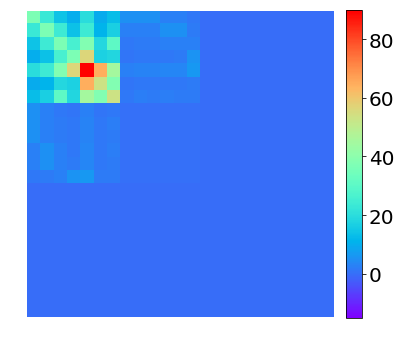

In [39]:
shape = (23, 23)
mat = x[rand_mol].reshape(shape)

plt.figure()
plt.figure(figsize = (6,6))
plt.imshow(mat, origin="upper", cmap='rainbow', vmin=-15, vmax=90, interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04).ax.tick_params(labelsize=20)
plt.axis('off')
plt.show()

Visualize the target data by plotting the distribution of HOMO energies in the dataset.

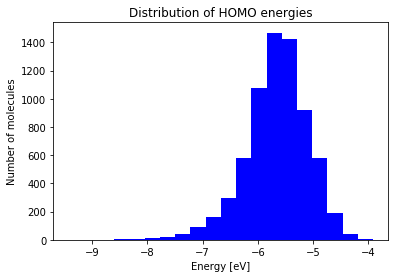

Mean value of HOMO energies in QM9 dataset: -5.66 eV


In [40]:
plt.hist(y, bins=20, density=False, facecolor='blue')
plt.xlabel("Energy [eV]")
plt.ylabel("Number of molecules")
plt.title("Distribution of HOMO energies")
plt.show()

## mean value of distribution
print("Mean value of HOMO energies in QM9 dataset: %0.2f eV" %np.mean(y))

Before dividing the dataset into training and test set, we shuffle the data. Data are often stored in a certain order, and simply taking the first part for training and the second for testing would not result in a well trained model, since the training set would not represent the test data well (and vice versa).

In [41]:
## shuffle the data

c = list(zip(x, y))
random.shuffle(c)

x, y = zip(*c)

x = np.array(x)
y = np.array(y)

Now, we divide the data into training and test set.

In [49]:
# decide how many samples to take from the database for training and testing
n_train = 2000
n_test = 1000

# split data in training and test
# take first n_train molecules for training
x_train  = x[0:n_train] 
y_train = y[0:n_train]

# take the next n_test data for testing
x_test = x[n_train:n_train + n_test]
y_test = y[n_train:n_train + n_test]

Check that the training data resemble the test data well by plotting the distribution of HOMO energies for both sets. The distributions should be centered around the same mean value and have the same shape.

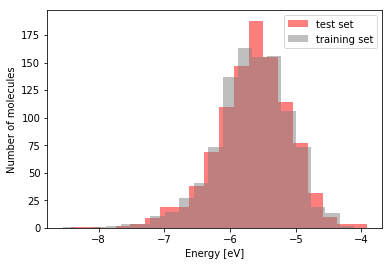

Mean value of HOMO energies in training set: -5.66 eV
Mean value of HOMO energies in test set: -5.66 eV


In [50]:
plt.hist(y_test, bins=20, density=False, alpha=0.5, facecolor='red', label='test set')
plt.hist(y_train, bins=20, density=False, alpha=0.5, facecolor='gray', label='training set')
plt.xlabel("Energy [eV]")
plt.ylabel("Number of molecules")
plt.legend()
plt.show()

## mean value of distributions
print("Mean value of HOMO energies in training set: %0.2f eV" %np.mean(y_train))
print("Mean value of HOMO energies in test set: %0.2f eV" %np.mean(y_test))

## Training

In the training phase we use a kernel function to measure the distance between all pairs of molecules (represented by their Coulomb matrices) in the training set. We here employ one of two kernels, the Gaussian kernel or the Laplacian kernel. The Gaussian kernel is given by

\begin{equation}
k_{Gaussian}(\boldsymbol{x},\boldsymbol{x}')=e^{-\frac{||{\boldsymbol{x}-\boldsymbol{x}'}||_2^2}{2\gamma^2}},
\end{equation}

which employs the Euclidean distance as similarity measure. The parameter $\gamma$ is defined as $\frac{1}{2\sigma^2}$, where $\sigma$ is the standard deviation of the Gaussian kernel (kernel width). The Laplacian kernel is given by

\begin{equation}
    k_{Laplacian}(\boldsymbol{x},\boldsymbol{x}')=e^{-\frac{||{\boldsymbol{x}-\boldsymbol{x}'}||_1}{\gamma}},
\end{equation}

which uses the 1-norm as similarity measure. Here, $\gamma$ is defined as $\frac{1}{\sigma}$, where $\sigma$ is the kernel width of the Laplacian kernel.

In the KRR training phase with $N$ training molecules, the machine learns the relationship between the molecules (represented by their Coulomb matrix) and their corresponding (pre-computed) HOMO energies. It does so by employing a function $f(\boldsymbol{x})$ that maps a training molecule $\boldsymbol{x}$ to its reference HOMO energy:

\begin{equation}
f(\boldsymbol{x}) = \sum_{i=1}^N \omega_i k(\boldsymbol{x}, \boldsymbol{x}_i) = HOMO^{ref},
\end{equation}

For a given training molecule $\boldsymbol{x}$, the distance to each molecule in the training set is computed by employing the kernel function $k$ (either Gaussian or Laplacian). Each kernel contribution (distance) is then weighted by a regression weight $\omega_i$. The above function is thus given by the weighted sum of kernel contributions (sum over $N$ training molecules). The purpose of training is to fit the regression weight $\omega_i$ so that HOMO$_{ref}$ is matched for each training molecule. In practice, the machine solves the minimization problem


\begin{equation}
 \underset{\omega}{min} \sum_{i=1}^N (f(\boldsymbol{x}_i) - HOMO^{ref}_i)^2 + \alpha \boldsymbol{\omega}^T \mathbf{K} \boldsymbol{\omega}.
\end{equation}

for a vector $\boldsymbol{\omega} \in \mathbb{R}^N = (\omega_1, \omega_2, ..., \omega_N)$ of regression weights. In KRR, the penalty term $ \alpha \boldsymbol{\omega}^T \mathbf{K} \boldsymbol{\omega}$ is added to the minimization problem in order to avoid over- and underfitting. Overfitting occurs when the model learns the training data too well, even the noise and other unimportant details. The model is unable to generalize on unseen data and therefore yields high prediction errors on the test data. Underfitting occurs when the model is too simple and does not learn the training data at all, and therefore is not able to predict test data well either. Both behaviours can be avoided by tuning the parameter $\alpha \in \left[0,1\right]$ to a reasonable value. This has do be done separately from training. Both the regularization parameter $\alpha$ and the kernel width $\gamma$ are so called hyperparameters. Hyperparameters cannot be learned during training and have to be selected beforehand. However, it is not always obvious how to choose these hyperparameters and it often requires intuition or rules of thumb. We here employ a cross-validated grid search in order to find the best values for these two hyperparameters. 

In grid search, a part of the training set is split off as validation set. We set up a grid of pre-defined hyperparameter values and train the machine on the remaining training set, for each possible combination of $\alpha$ and $\gamma$ values. We validate each possible combination by making predictions on the validation set. The two hyperparameter values that yield the best performance (lowest error) are then selected for the final model to make predictions on the test set.

In cross-validation, the roles of training and validation sets alternate. As described above, a part from the training set is split off as validation set. After training one combination of hyperparameters on the remaining training set and validating on the validation set, the validation set becomes the training set and vice versa, and the model is trained on the new training set and validated on the new validation set for the same combination of hyperparameters. The ratio can be varied, for example in 5-fold cross-validation, the training set is split in 5 equal parts. For each combination of hyperparameters, the model is trained on 80% of the data and validated on the other 20%. Then the roles of training and validation set rotate until each part has served as validation set exactly once. The final validation error for one particular combination of hyperparameters is computed as the mean from all 5 errors on the 5 validation sets. The combination with lowest average error is chosen for the final model.

The cross-validated grid search routine is implemented in scikit-learn.

In [51]:
# set up grids for alpha and gamma hyperparameters. 
# first value: lower bound; second value: upper bound; 
# third value: number of points to evaluate (here set to '3' --> '-2', '-1' and '0' are evaluated)
# --> make sure to change third value as well when changing the bounds!
alpha = np.logspace(-5, -2, 4)
gamma = np.logspace(-5, -2, 4)

cv_number = 5 ## choose into how many parts training set is divided for cross-validation
kernel = 'laplacian' # select kernel function here ('rbf': Gaussian kernel, 'laplacian': Laplacian kernel)
scoring_function = 'neg_mean_absolute_error' # it is called "negative" because scikit-learn interprets
                                             # highest scoring value as best, but we want small errors

## define settings for grid search routine in scikit-learn with above defined grids as input

grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                           [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}], 
                           cv = cv_number, 
                           scoring = scoring_function,
                           verbose=1000)  ## produces detailed output statements of grid search 
                                          # routine so we can see what is computed
    
# call the fit function in scikit-learn which fits the Coulomb matrices in the training set 
# to their corresponding HOMO energies.
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=1e-05, gamma=1e-05, kernel=laplacian ......................
[CV]  alpha=1e-05, gamma=1e-05, kernel=laplacian, score=-0.274, total=   0.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=1e-05, gamma=1e-05, kernel=laplacian ......................
[CV]  alpha=1e-05, gamma=1e-05, kernel=laplacian, score=-0.244, total=   0.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[CV] alpha=1e-05, gamma=1e-05, kernel=laplacian ......................
[CV]  alpha=1e-05, gamma=1e-05, kernel=laplacian, score=-0.308, total=   0.7s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[CV] alpha=1e-05, gamma=1e-05, kernel=laplacian ......................
[CV]  alpha=1e-05, gamma=1e-05, kernel=laplacian, score=-0.302, total=   0.6s
[Parallel(n_jobs=1)]: 

[CV]  alpha=0.0001, gamma=0.01, kernel=laplacian, score=-1.353, total=   0.5s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   20.0s remaining:    0.0s
[CV] alpha=0.0001, gamma=0.01, kernel=laplacian ......................
[CV]  alpha=0.0001, gamma=0.01, kernel=laplacian, score=-1.147, total=   0.5s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   20.5s remaining:    0.0s
[CV] alpha=0.0001, gamma=0.01, kernel=laplacian ......................
[CV]  alpha=0.0001, gamma=0.01, kernel=laplacian, score=-1.271, total=   0.5s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   21.0s remaining:    0.0s
[CV] alpha=0.0001, gamma=0.01, kernel=laplacian ......................
[CV]  alpha=0.0001, gamma=0.01, kernel=laplacian, score=-1.304, total=   0.5s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   21.5s remaining:    0.0s
[CV] alpha=0.0001, gamma=0.01, kernel=laplacian ......................
[CV]  alpha=0.0001, gamma=0.01, kernel=laplacian, score=-1.208, total=   0.5s
[Paral

[CV]  alpha=0.01, gamma=0.001, kernel=laplacian, score=-0.238, total=   0.5s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   39.3s remaining:    0.0s
[CV] alpha=0.01, gamma=0.001, kernel=laplacian .......................
[CV]  alpha=0.01, gamma=0.001, kernel=laplacian, score=-0.294, total=   0.5s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   39.8s remaining:    0.0s
[CV] alpha=0.01, gamma=0.001, kernel=laplacian .......................
[CV]  alpha=0.01, gamma=0.001, kernel=laplacian, score=-0.304, total=   0.5s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   40.4s remaining:    0.0s
[CV] alpha=0.01, gamma=0.001, kernel=laplacian .......................
[CV]  alpha=0.01, gamma=0.001, kernel=laplacian, score=-0.270, total=   0.5s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   40.9s remaining:    0.0s
[CV] alpha=0.01, gamma=0.01, kernel=laplacian ........................
[CV]  alpha=0.01, gamma=0.01, kernel=laplacian, score=-1.360, total=   0.5s
[Parallel(n_

GridSearchCV(cv=5, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='linear', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02]),
                          'gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02]),
                          'kernel': ['laplacian']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=1000)

## Grid search results

Print out the average validation errors and corresponding hyperparameter combinations

In [52]:
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(-means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.284 (+/-0.046) for {'alpha': 1e-05, 'gamma': 1e-05, 'kernel': 'laplacian'}
0.278 (+/-0.045) for {'alpha': 1e-05, 'gamma': 0.0001, 'kernel': 'laplacian'}
0.278 (+/-0.045) for {'alpha': 1e-05, 'gamma': 0.001, 'kernel': 'laplacian'}
1.257 (+/-0.145) for {'alpha': 1e-05, 'gamma': 0.01, 'kernel': 'laplacian'}
0.277 (+/-0.042) for {'alpha': 0.0001, 'gamma': 1e-05, 'kernel': 'laplacian'}
0.277 (+/-0.044) for {'alpha': 0.0001, 'gamma': 0.0001, 'kernel': 'laplacian'}
0.278 (+/-0.045) for {'alpha': 0.0001, 'gamma': 0.001, 'kernel': 'laplacian'}
1.257 (+/-0.145) for {'alpha': 0.0001, 'gamma': 0.01, 'kernel': 'laplacian'}
0.277 (+/-0.038) for {'alpha': 0.001, 'gamma': 1e-05, 'kernel': 'laplacian'}
0.273 (+/-0.041) for {'alpha': 0.001, 'gamma': 0.0001, 'kernel': 'laplacian'}
0.278 (+/-0.045) for {'alpha': 0.001, 'gamma': 0.001, 'kernel': 'laplacian'}
1.257 (+/-0.145) for {'alpha': 0.001, 'gamma': 0.01, 'kernel': 'laplacian'}
0.303 (+/-0.040) for {'alpha': 0.01, 'gamma': 1e-05, 'kernel': 'laplacia

Next, we visualize the grid search results by plotting a heatmap.

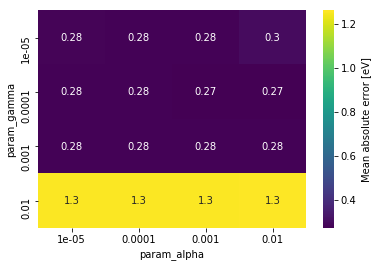

The best combinations of parameters are {'alpha': 0.001, 'gamma': 0.0001, 'kernel': 'laplacian'} with a score of 0.273 eV on the validation set.


In [53]:
results = pd.DataFrame(grid_search.cv_results_)
#pd.DataFrame(grid_search.cv_results_)

pvt = pd.pivot_table(results, values='mean_test_score', 
                     index='param_gamma', columns='param_alpha')
heatmap = sns.heatmap(-pvt, annot=True, cmap='viridis', cbar_kws={'label': "Mean absolute error [eV]"})
figure = heatmap.get_figure()
plt.show()


print("The best combinations of parameters are %s with a score of %0.3f eV on the validation set."
      % (grid_search.best_params_, -grid_search.best_score_))

## Testing

With the best combination of hyperparameters, the model is once again trained on the entire training set (this is done automatically in scikit-learn). Then, with the best combination of hyperparameters, predictions are made on the test set to evaluate the final model. With the fitted regressions weights $\omega_i$ and the selected hyperparameter $\gamma$ (kernel width), the final model is used to predict the energies of the test molecules. The energy of a particular test molecule $\boldsymbol{x}$ is predicted by computing the weighted sum of kernel contributions $k(\boldsymbol{x}, \boldsymbol{x}_i)$ between the test molecule $\boldsymbol{x}$ and each of the $N$ molecules $\boldsymbol{x}_i$ in the training set (sum over $N$):

\begin{equation}
f(x) = \sum_{i=1}^N \omega_i k(\boldsymbol{x}, \boldsymbol{x}_i) = HOMO^{pred},
\end{equation}

The deviation of the predicted HOMO energies to the true reference HOMO energies yields the final error of the model. We compute the mean absolute error between predicted and reference HOMO energies for all $M$ test molecules (sum over $M$):

\begin{equation}
\sum_{i=1}^M \frac{1}{M} \big|HOMO^{pred} - HOMO^{ref}\big|
\end{equation}


Mean absolute error on test set: 0.256 eV


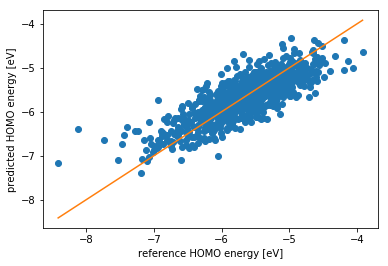

R^2 score on test set: 0.651


In [54]:
# predicted HOMO energies for all test molecules

y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination
                                     # of hyperparameters from grid search

print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

# do the regression plot
plt.plot(y_test, y_pred, 'o')
plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
plt.xlabel('reference HOMO energy [eV]')
plt.ylabel('predicted HOMO energy [eV]')
plt.show()
print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))

The $R^2$ score indicates how close the predicted energies in the test set are to the reference energies. The closer the points in the above figure are located to the diagonal, the better the predictions. Points on the diagonal ("predicted energy"="reference energy") correspond to $R^2=1$. Therefore, $R^2$ values close to 1 indicate good model performance.

## Exercises

### 1. Grid search

Increase the number and range of grid points used for grid search. Which combination of $\alpha$ and $\gamma$ works best? How does the computational time increase? Choose a reasonable number of grid points that don't take too long to evaluate.

### 2. Cross-validation

Increase the number of folds used for cross-validation. Does the quality of the model increase? Take note as well of the increasing computational time and choose a number of folds that does not require too much computational time.

### 3. Kernel function

Use the Laplacian kernel instead of the Gaussian kernel. Which kernel leads to better model performance?

### 4. Training set size

Using the better performing kernel, let's investigate the effects of training set size on the final model.

Increase the size of the training set and plot the mean absolute error on the test set as a function of training set size (e.g. use 1000, 2000, 3000 etc. as training set size). How does the computational time increase? What is the largest training set size that allows training within a reasonable time, given computational resources?

The optimal hyperparameter values for $\alpha$ and $\gamma$ can change throughout varying training set sizes. Therefore, when increasing the training set size, it is recommended to perform a cross-validated grid search for each training set size. Use a reasonable amount of grid points as well as a reasonable number of folds for cross-validation. Take note of the optimal hyperparameters for each training set size. Do they change? 